# Plotting the MAPE score of DeepState for every horizon on all data-sets.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def calculate_mape(repetitions, num_timeseries, num_windows=7, horizon_len=24):
    dfs = []
    for rep in repetitions:
        samples = rep[rep.columns[3:]].values.reshape(num_timeseries, num_windows, horizon_len, 100)
        target = rep["target"].values.reshape(num_timeseries, num_windows, horizon_len)

        preds = samples.mean(axis=-1)
        
        # Calculate MAPE like in GluonTS evaluator
        denominator = np.abs(target)
        flag = denominator == 0
        mape = np.mean((np.abs(target - preds) * (1 - flag)) / (denominator + flag), axis=1).mean(axis=0)

        metrics_df = pd.DataFrame(
            data=mape.reshape([-1, 1]),
            columns=["MAPE"]
            ).rename_axis("index")
        dfs.append(metrics_df)
        
    return dfs

In [3]:
def load_forecasts(experiment_path):
    repetitions = []
    for folder in sorted(os.listdir(experiment_path)):
        repetitions.append(pd.read_csv(f"{experiment_path}/{folder}/forecasts.csv", index_col=0).rename_axis("index"))
    return repetitions

In [4]:
path = "/datadrive/experiments/deepstate"
elec_exp = load_forecasts(f"{path}/electricity/2B")
traffic_exp = load_forecasts(f"{path}/traffic_nips/2B")
solar_exp = load_forecasts(f"{path}/solar_nips/2B")
exch_exp = load_forecasts(f"{path}/exchange_rate/2B")

In [5]:
elec_exp = calculate_mape(elec_exp, 321)
traffic_exp = calculate_mape(traffic_exp, 963)
solar_exp = calculate_mape(solar_exp, 137)
exch_exp = calculate_mape(exch_exp, 8, 5, 30)

In [6]:
elec_array = np.concatenate(elec_exp).reshape(100, 24)
traffic_array = np.concatenate(traffic_exp).reshape(100, 24)
solar_array = np.concatenate(solar_exp).reshape(100, 24)
exch_array = np.concatenate(exch_exp).reshape(100, 30)

In [7]:
def create_boxplot(all, worst10, best10, label, horizon):
    fig = plt.figure(figsize=(15, 7))

    plt.boxplot(
        worst10,
        positions=np.array([i for i in range(0, horizon * 2, 2)]) * 2 - 1.25,
        sym='',
        patch_artist=True,
        boxprops={"facecolor": "C0"},
        medianprops={"color": "black"}
    )
    plt.boxplot(
        all,
        positions=np.array([i for i in range(0, horizon * 2, 2)]) * 2,
        sym='',
        patch_artist=True,
        boxprops={"facecolor": "C1"},
        medianprops={"color": "black"}
    )
    plt.boxplot(
        best10,
        positions=np.array([i for i in range(0, horizon * 2, 2)]) * 2 + 1.25,
        sym='',
        patch_artist=True,
        boxprops={"facecolor": "C2"},
        medianprops={"color": "black"}
    )
    # draw empty lines to create a legend
    plt.plot([], c='C0', label='10 worst')
    plt.plot([], c='C1', label='All')
    plt.plot([], c="C2", label="10 best")
    plt.legend()
    plt.title(label)

    plt.xticks([i for i in range(0, horizon * 4, 4)], ["t" + str(i) for i in range(1, horizon + 1)])

In [8]:
elec_all = list(elec_array.T)
elec_worst10 = list(elec_array[np.argsort(elec_array.mean(axis=1))[-10:]].T)
elec_best10 = list(elec_array[np.argsort(elec_array.mean(axis=1))[:10]].T)

traffic_all = list(traffic_array.T)
traffic_worst10 = list(traffic_array[np.argsort(traffic_array.mean(axis=1))[-10:]].T)
traffic_best10 = list(traffic_array[np.argsort(traffic_array.mean(axis=1))[:10]].T)

solar_all = list(solar_array.T)
solar_worst10 = list(solar_array[np.argsort(solar_array.mean(axis=1))[-10:]].T)
solar_best10 = list(solar_array[np.argsort(solar_array.mean(axis=1))[:10]].T)

exch_all = list(exch_array.T)
exch_worst10 = list(exch_array[np.argsort(exch_array.mean(axis=1))[-10:]].T)
exch_best10 = list(exch_array[np.argsort(exch_array.mean(axis=1))[:10]].T)

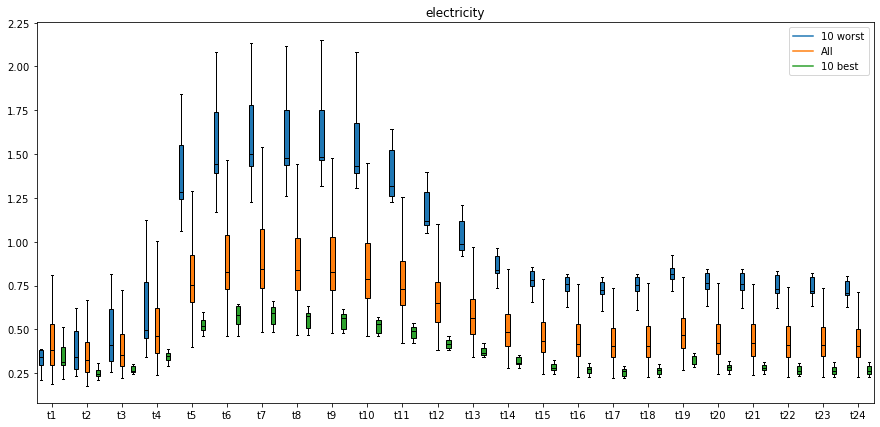

In [9]:
create_boxplot(elec_all, elec_worst10, elec_best10, "electricity", 24)

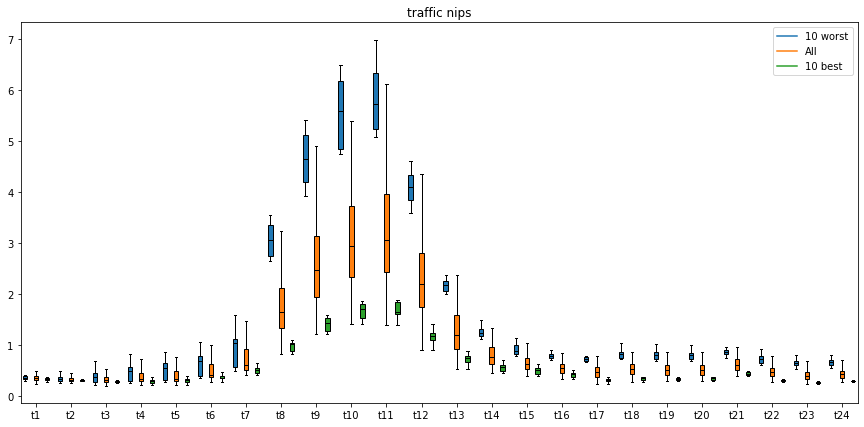

In [10]:
create_boxplot(traffic_all, traffic_worst10, traffic_best10, "traffic nips", 24)

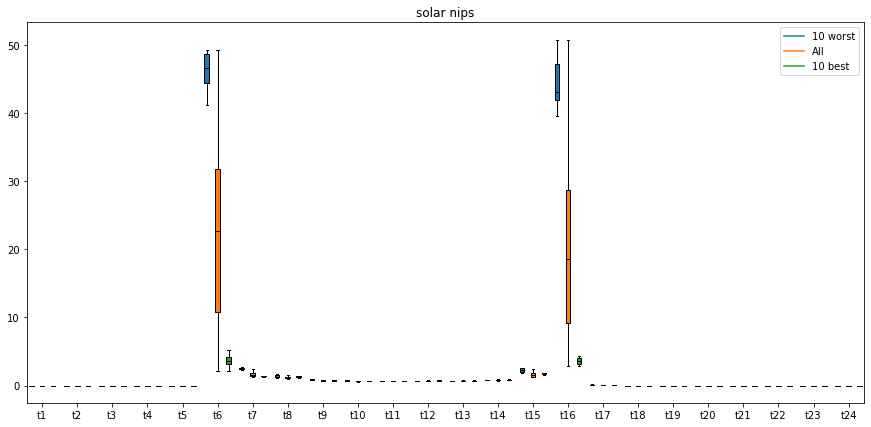

In [11]:
create_boxplot(solar_all, solar_worst10, solar_best10, "solar nips", 24)

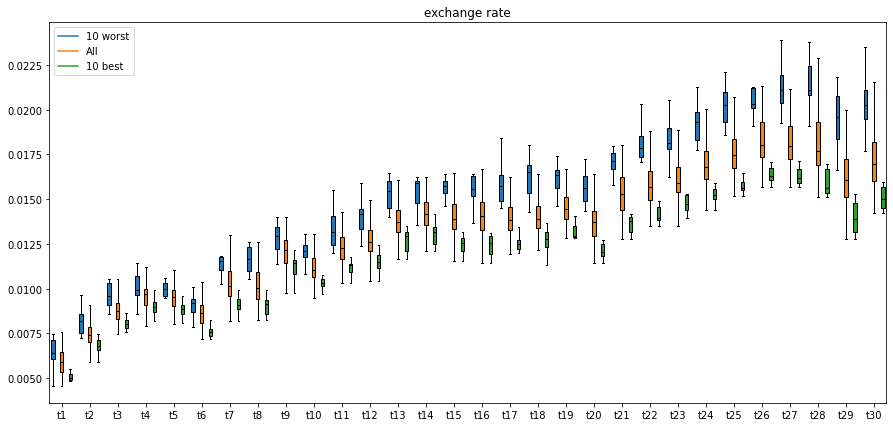

In [12]:
create_boxplot(exch_all, exch_worst10, exch_best10, "exchange rate", 30)